In [1]:
import cv2, os
from tqdm import tqdm
import numpy as np

In [2]:
import tensorflow as tf
from tensorflow.python.keras.utils.multi_gpu_utils import multi_gpu_model


gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Configure which GPU(s) to use
    tf.config.experimental.set_visible_devices(gpus, 'GPU')
    # Enable memory growth for each GPU
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
model = Model(inputs=base_model.input, outputs=x)

In [5]:
path = "dataset/train/"

trainX = []
trainY = []
for classes in tqdm(os.listdir(path)):
    class_ = path + classes
    for images in os.listdir(class_):
        try:
            image_path = class_ + '/' + images
            image = cv2.imread(image_path)
            image = cv2.resize(image,(224,224))
            image = np.expand_dims(image,axis=0)
            features = model.predict(image)[0]
            trainX.append(features)
            trainY.append(class_.split('/')[-1])
        except:
            continue

100%|██████████| 6/6 [2:53:03<00:00, 1730.52s/it]  


In [6]:
trainX = np.array(trainX)
trainY = np.array(trainY)

In [7]:
path = "dataset/test/"

testX = []
testY = []
for classes in tqdm(os.listdir(path)):
    class_ = path + classes
    for images in os.listdir(class_):
        try:
            image_path = class_ + '/' + images
            image = cv2.imread(image_path)
            image = cv2.resize(image,(224,224))
            image = np.expand_dims(image,axis=0)
            features = model.predict(image)[0]
            testX.append(features)
            testY.append(class_.split('/')[-1])
        except:
            continue

100%|██████████| 6/6 [21:35<00:00, 215.92s/it]


In [8]:
testX = np.array(testX)
testY = np.array(testY)

In [9]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
trainY = le.fit_transform(trainY)
testY = le.fit_transform(testY)
trainY = to_categorical(trainY, 6)
testY = to_categorical(testY, 6)
print(trainX.shape,testX.shape,trainY.shape,testY.shape)

(171125, 2048) (21392, 2048) (171125, 6) (21392, 6)


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [11]:
model1 = Sequential()

# Add the input layer
model1.add(Dense(units=1024, activation='relu', input_dim=2048))

# Add more hidden layers
model1.add(Dense(units=512, activation='relu'))
model1.add(Dense(units=256, activation='relu'))
model1.add(Dense(units=128, activation='relu'))

# Add the output layer
model1.add(Dense(units=6, activation='softmax'))
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 774       
Total params: 2,787,974
Trainable params: 2,787,974
Non-trainable params: 0
_________________________________________________________________


In [12]:
num_gpus = 2
multi_model = multi_gpu_model(model1, gpus=num_gpus)

In [13]:
multi_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])#, class_weight=class_weight_dict)

In [14]:
multi_model.fit(trainX, trainY, epochs=6, validation_data = (testX,testY), batch_size=128)

Epoch 1/6
1337/1337 [==============================] - 8s 6ms/step - loss: 0.4480 - accuracy: 0.8474 - val_loss: 0.2705 - val_accuracy: 0.9045
Epoch 2/6
1337/1337 [==============================] - 7s 5ms/step - loss: 0.2439 - accuracy: 0.9143 - val_loss: 0.2357 - val_accuracy: 0.9181
Epoch 3/6
1337/1337 [==============================] - 7s 6ms/step - loss: 0.2048 - accuracy: 0.9278 - val_loss: 0.2290 - val_accuracy: 0.9215
Epoch 4/6
1337/1337 [==============================] - 7s 5ms/step - loss: 0.1743 - accuracy: 0.9373 - val_loss: 0.2319 - val_accuracy: 0.9213
Epoch 5/6
1337/1337 [==============================] - 7s 5ms/step - loss: 0.1512 - accuracy: 0.9453 - val_loss: 0.2432 - val_accuracy: 0.9226
Epoch 6/6
1337/1337 [==============================] - 7s 5ms/step - loss: 0.1340 - accuracy: 0.9500 - val_loss: 0.2285 - val_accuracy: 0.9247


In [15]:
multi_model.save("nfsw.h5")

In [16]:
from tensorflow.keras.models import load_model

mymodel = load_model("nfsw.h5")
classes = open("classes.txt",'r').read().split('\n')[:-1]
print(classes)

['explicit_moderation', 'gore_moderation', 'intoxicants_moderation', 'sfw_moderation', 'suggestive_moderation', 'weapons_moderation']


In [17]:
path = "dataset/validation/"

validY = []
predY = []
for class_path in tqdm(os.listdir(path)):
    class_ = path + class_path
    for images in os.listdir(class_):
        try:
            image_path = class_ + '/' + images
            image = cv2.imread(image_path)
            image = cv2.resize(image,(224,224))
            image = np.expand_dims(image,axis=0)
            features = model.predict(image)[0]
            features = np.expand_dims(features,axis=0)
            pred = mymodel.predict(features)[0]
            name = classes[np.argmax(pred)]
            predY.append(name)
            validY.append(class_.split('/')[2])
        except:
            print(image_path)

 67%|██████▋   | 4/6 [32:19<19:00, 570.03s/it]

dataset/validation/intoxicants_moderation/000419.gif


100%|██████████| 6/6 [35:48<00:00, 358.11s/it]


In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

In [19]:
len(validY), len(predY), validY[0], predY[0]

(21396, 21396, 'gore_moderation', 'gore_moderation')

In [20]:
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

print(classification_report(validY, predY))

                        precision    recall  f1-score   support

   explicit_moderation       0.94      0.93      0.94      7540
       gore_moderation       0.85      0.93      0.89      1034
intoxicants_moderation       0.90      0.80      0.85      1057
        sfw_moderation       0.93      0.96      0.95      9236
 suggestive_moderation       0.86      0.74      0.80      1526
    weapons_moderation       0.94      0.91      0.92      1003

              accuracy                           0.92     21396
             macro avg       0.90      0.88      0.89     21396
          weighted avg       0.92      0.92      0.92     21396



In [21]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(validY, predY)

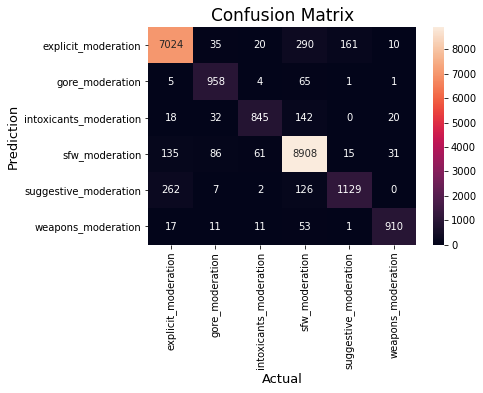

In [22]:
sns.heatmap(conf_matrix,
            annot=True,
            fmt='g',
            xticklabels=classes,
            yticklabels=classes,
    )
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(validY, predY)
precision = precision_score(validY, predY,average='weighted')
recall = recall_score(validY, predY,average='weighted')
f1 = f1_score(validY, predY,average='weighted')

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.9241914376518976
Precision: 0.9237547861738258
Recall: 0.9241914376518976
F1 Score: 0.9232529966480739
